<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA6_S12_STN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%matplotlib inline
!nvidia-smi

Sat Jul 31 07:56:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    913MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


Spatial Transformer Networks on CIFAR10 Dataset
=====================================

This Notebook was originally inspired from  `Ghassen HAMROUNI <https://github.com/GHamrouni>`


In this notebook, we will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the `DeepMind paper <https://arxiv.org/abs/1506.02025>`__

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [2]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [14]:
!git clone https://github.com/rajy4683/mini-Rekog.git

Cloning into 'mini-Rekog'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 168 (delta 95), reused 122 (delta 51), pack-reused 0
Receiving objects: 100% (168/168), 54.99 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
!pip install -r /content/mini-Rekog/requirements.txt

In [ ]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install -U albumentations

In [32]:
import sys
sys.path.append("/content/mini-Rekog")
from miniRekog.models.CIFAR10Models import CIFARModelDDilate

Loading the data
----------------

We will use CIFA10 dataset for our experimentation



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader_cifar = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([                                                 
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4826, 0.44653), (0.24703, 0.24349, 0.26519))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader_cifar = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4826, 0.44653), (0.24703, 0.24349, 0.26519))
    ])), batch_size=64, shuffle=True, num_workers=4)


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

The output of the STN network is sent through a custom Convolution network for performing complete classification. 



In [ ]:
class STN_Cifar(nn.Module):
    def __init__(self,n_channels=1):
        super(STN_Cifar, self).__init__()
        # self.conv1 = nn.Conv2d(n_channels, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        # self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        # self.conv3_drop = nn.Dropout2d()
        self.custom_conv = CIFARModelDDilate()
        # self.fc1 = nn.Linear(500, 50)
        # self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(n_channels, 8, kernel_size=3),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.Conv2d(8, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # # x = F.relu(self.conv3_drop(self.conv3(x)), 2)
        # x = x.view(-1, 500)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)

        return self.custom_conv(x)
        # return F.log_softmax(x, dim=1)


# model = Net(n_channels=3).to(device)

In [24]:
class STN_Cifar(nn.Module):
    def __init__(self,n_channels=1):
        super(STN_Cifar, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(n_channels, 8, kernel_size=3),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.Conv2d(8, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = F.relu(self.conv3_drop(self.conv3(x)), 2)
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return x
        return F.log_softmax(x, dim=1)


# model = Net(n_channels=3).to(device)

In [46]:
model_cifar = STN_Cifar(n_channels=3).to(device)
model_cifar(data_cifar).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([64, 10])

In [51]:
from torchsummary import summary
summary(model_cifar, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
            Conv2d-2            [-1, 8, 28, 28]             584
            Conv2d-3            [-1, 8, 22, 22]           3,144
         MaxPool2d-4            [-1, 8, 11, 11]               0
              ReLU-5            [-1, 8, 11, 11]               0
            Conv2d-6             [-1, 10, 7, 7]           2,010
         MaxPool2d-7             [-1, 10, 3, 3]               0
              ReLU-8             [-1, 10, 3, 3]               0
            Linear-9                   [-1, 32]           2,912
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 6]             198
           Conv2d-12           [-1, 24, 32, 32]             648
      BatchNorm2d-13           [-1, 24, 32, 32]              48
             ReLU-14           [-1, 24,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [23]:
!python /content/mini-Rekog/miniRekog/training_scripts/train_s12eva6.py -p '{"lr":0.01,"ocp_max_lr":0.01, "momentum":0.9, "epochs":50, "weight_decay":0.0}'

  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.01
Setting  ocp_max_lr  =  0.01
Setting  momentum  =  0.9
Setting  epochs  =  50
Setting  weight_decay  =  0.0
Final Hyperparameters
dropout: 0.1
batch_size: 512
test_batch_size: 128
lr: 0.01
momentum: 0.9
no_cuda: False
seed: 1
epochs: 50
bias: False
sched_lr_gamma: 0.5
sched_lr_step: 1
start_lr: 0
weight_decay: 0.0
reg_l1: False
reg_l2: False
norm_strategy: BatchNorm
lr_decay_threshold: 0.0
factor: 0.0
project: news5
ocp_max_lr: 0.01
final_div_factor: 64
div_factor: 128
anneal_strategy: linear
pct_start: 0.208
cycle_momentum: False
lr_policy: ocp
split_pct: 0.208
unfreeze_layer: 3
Initializing datasets and dataloaders
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:122: FutureWarning: IAAFliplr is deprecated. Ple

### Accuracy Curves

In the training mechanism above we have removed Image Augmentation altogether. We see a significant drop in accuracy but we can experiment further with deeper localization layers and get better accuracy.

In [33]:
import sys
sys.path.append("/content/mini-Rekog")
from miniRekog.utils import logger
from miniRekog.utils import fileutils
from miniRekog.models.CIFAR10Models import STN_Cifar
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 10)

import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly"

In [27]:
run_list = ['rajy4683/news5/runs/1je187p8']

runs_df = logger.get_wandb_dataframes(run_list=run_list)
new_df = pd.DataFrame().append(runs_df)

In [28]:
fig = new_df[['Train Accuracy', 'Test Accuracy']].plot()


In [ ]:
from IPython import display
display.Image("/content/EVA6S8_Accuracy.png")

In [29]:
# model_cifar = STN_Cifar(n_channels=3).to(device)
model_cifar = torch.load('/content/model_saves/model-48d3312fd3.pt', )

In [49]:
model_cifar = STN_Cifar(n_channels=3).to(device)
model_cifar.load_state_dict(torch.load('/content/model_saves/model-48d3312fd3.pt' )['model_state_dict'])

<All keys matched successfully>

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of gri

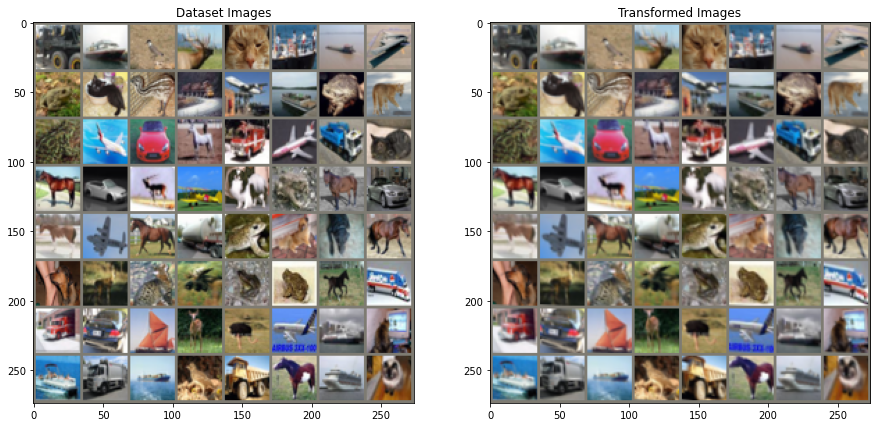

In [50]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.49421428, 0.48513139, 0.45040909])
    std = np.array([0.24665252, 0.24289226, 0.26159238])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn(model, test_loader):
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')



# Visualize the STN transformation on some input batch
visualize_stn(model_cifar, test_loader_cifar)

plt.ioff()
plt.show()

### Outputs from intermediate model saves


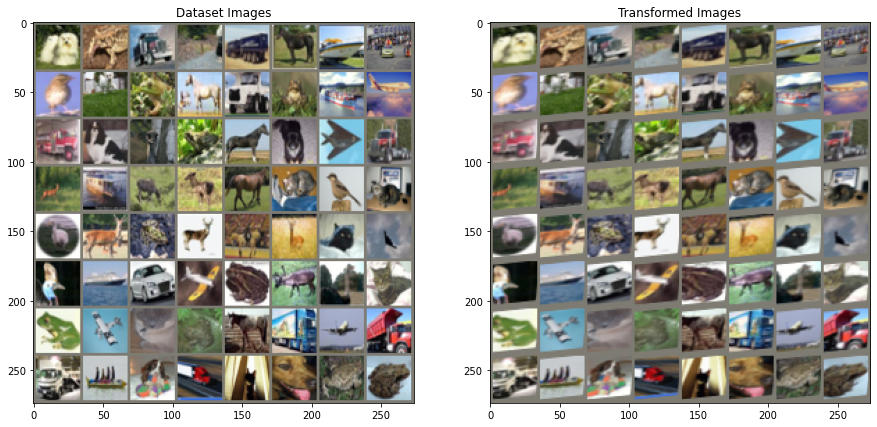

In [51]:
from IPython import display
display.Image("/content/STN40.png")

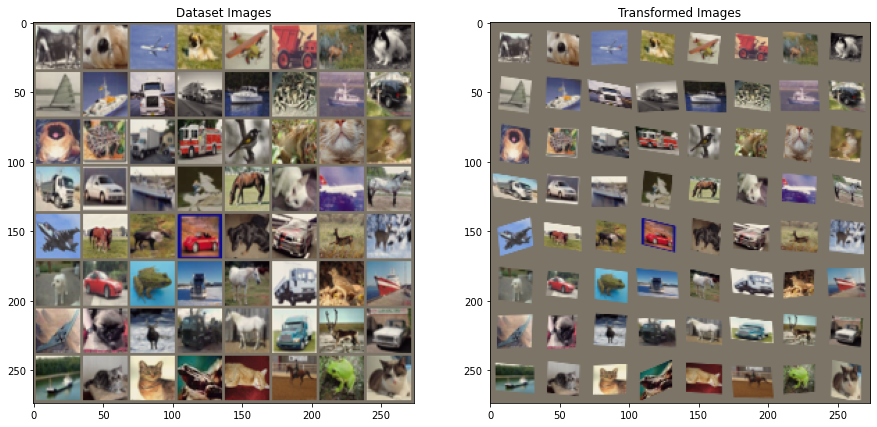

In [53]:
from IPython import display
display.Image("/content/STN64.png")